# SED Fitting and Supernova Analysis Module 

**Lecturer:** Samaporn Tinyanont<br>
**Jupyter Notebook Authors:** Samaporn Tinyanont

This is a Jupyter notebook lesson taken from the NARIT HOWonOAR 2023.  


## Objective
Fit a black body function to multi-band photometry to measure the black body temperature, radius, and luminosity. Then reiterate this process to derive a bolometric light curve for a supernova.

## Key steps
- Plot spectral energy distribution (SED)
- Write a function that produce black body flux as a function of temperature and radius
- Use scipy curve fit to fit this function to provided data
- Reiterate this process for the entire light curve to make a bolometric light curve

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* matplotlib
* scipy

### External packages
None

In [20]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os

import astropy.constants as const
import astropy.units as u
import astropy.io.ascii as asci

from scipy.optimize import curve_fit


## Load up the data and plot multi-band light curves

In [21]:
data_dir = 'data/'

Load the provided multi-band light curve

First, we need to load our supernova light curve in many bands. In this case, the light curve is simplified and every epoch has data in every band. 

This file contains light curves in gri bands of SN 2015bn, obtained by the Las Cumbres Observatory. The data are taken from https://github.com/mnicholl/superbol/blob/master/example/2015bn_abs_ugriz.txt

In [22]:
# Load up our data and print it in the table format

sn_light_curve = asci.read(data_dir+'/2015bn_simplified.txt')
sn_light_curve.show_in_notebook()

idx,epoch,g,gerr,r,rerr,i,ierr
0,-26.41,-21.75,0.04,-21.53,0.06,-21.31,0.07
1,-25.25,-21.74,0.09,-21.49,0.06,-21.33,0.08
2,-21.89,-21.72,0.03,-21.59,0.06,-21.36,0.06
3,-18.41,-21.76,0.08,-21.51,0.06,-21.43,0.04
4,-15.07,-21.91,0.09,-21.56,0.08,-21.51,0.06
5,-9.9,-21.87,0.03,-21.69,0.13,-21.55,0.11
6,-6.4,-21.92,0.04,-21.76,0.07,-21.61,0.09
7,-3.04,-21.95,0.06,-21.72,0.05,-21.62,0.04
8,0.47,-21.97,0.04,-21.81,0.06,-21.64,0.06
9,3.99,-21.93,0.14,-21.7,0.13,-21.59,0.13


In [23]:
#You can select specific columns like so
sn_light_curve['epoch', 'g']

epoch,g
float64,float64
-26.41,-21.75
-25.25,-21.74
-21.89,-21.72
-18.41,-21.76
-15.07,-21.91
-9.9,-21.87
-6.4,-21.92
-3.04,-21.95
0.47,-21.97


In [24]:
#You can also dice the table to select desired row in many ways:
sn_light_curve[[0,1, 5, 6]]

epoch,g,gerr,r,rerr,i,ierr
float64,float64,float64,float64,float64,float64,float64
-26.41,-21.75,0.04,-21.53,0.06,-21.31,0.07
-25.25,-21.74,0.09,-21.49,0.06,-21.33,0.08
-9.9,-21.87,0.03,-21.69,0.13,-21.55,0.11
-6.4,-21.92,0.04,-21.76,0.07,-21.61,0.09


In [25]:
sn_light_curve[sn_light_curve['epoch'] < 0] #select all rows where the column epoch is < 0
# in general, in the bracket parenthesis can be any boolean array with the same length as the table
# and you will get the rows for which this boolean array value is True

epoch,g,gerr,r,rerr,i,ierr
float64,float64,float64,float64,float64,float64,float64
-26.41,-21.75,0.04,-21.53,0.06,-21.31,0.07
-25.25,-21.74,0.09,-21.49,0.06,-21.33,0.08
-21.89,-21.72,0.03,-21.59,0.06,-21.36,0.06
-18.41,-21.76,0.08,-21.51,0.06,-21.43,0.04
-15.07,-21.91,0.09,-21.56,0.08,-21.51,0.06
-9.9,-21.87,0.03,-21.69,0.13,-21.55,0.11
-6.4,-21.92,0.04,-21.76,0.07,-21.61,0.09
-3.04,-21.95,0.06,-21.72,0.05,-21.62,0.04


Text(0.5, 1.0, 'SN 2015bn')

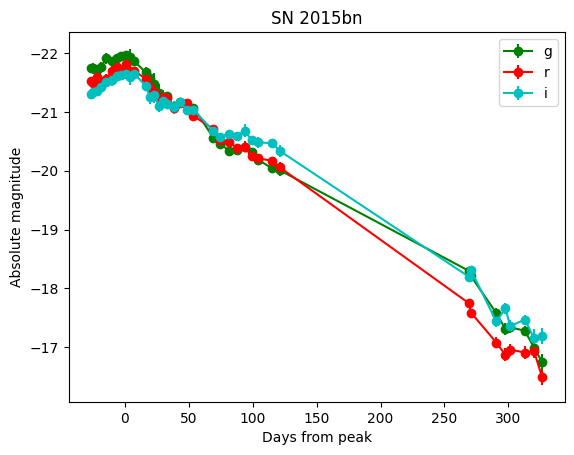

In [26]:
# Plot the light curve in different bands using different colors to mark different bands. 
# Take care to invert the y axis so that small magnitude (bright) is on top

plt.errorbar(sn_light_curve['epoch'], sn_light_curve['g'], yerr = sn_light_curve['gerr'], marker = 'o', color = 'g', label = 'g')
plt.errorbar(sn_light_curve['epoch'], sn_light_curve['r'], yerr = sn_light_curve['rerr'], marker = 'o', color = 'r', label = 'r')
plt.errorbar(sn_light_curve['epoch'], sn_light_curve['i'], yerr = sn_light_curve['ierr'], marker = 'o', color = 'c', label = 'i')

plt.legend()

plt.gca().invert_yaxis()

plt.xlabel('Days from peak')
plt.ylabel('Absolute magnitude')

plt.title('SN 2015bn')

Here, you can see a typical light curve of a supernova: quick rise to a peak, then a long decline. This supernova is a rare subtype called a "superluminous" supernova, and this particular object is one of the best studied. 

These three light curves show the photometric evolution of this supernova in three different filters. In the next steps, we will estimate the bolometric light curve of this object. 

## Spectral Energy Distribution

A spectral energy distribution, or SED, is sort of a spectrum but with a very low resolution made with only a few filters. While it cannot show detailed spectral features like lines from different elements, it can be used to measure  the overall shape of the continuum, which is temperature dependent.   

Let's plot SED from three different epochs to see the temperature evolution of SN 2015bn. These three epochs selected represent early time, at peak, and late time SED of the supernova.  

In [27]:
# First we define the three epochs we're interested in
epoch1 = sn_light_curve['epoch'] == -26.41 #this is just the first epoch
epoch2 = sn_light_curve['epoch'] == -25.25 #pick something close to peak
epoch3 = sn_light_curve['epoch'] == -18.41 #pick something else at later times

In [28]:
# We now need to obtain the wavelength of these filters
# Again, SVO filter service is very useful: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=LasCumbres
# Here, we use lambda_mean in Angstrom

g_wave = 4749.16
r_wave = 6235.29
i_wave = 7632.28

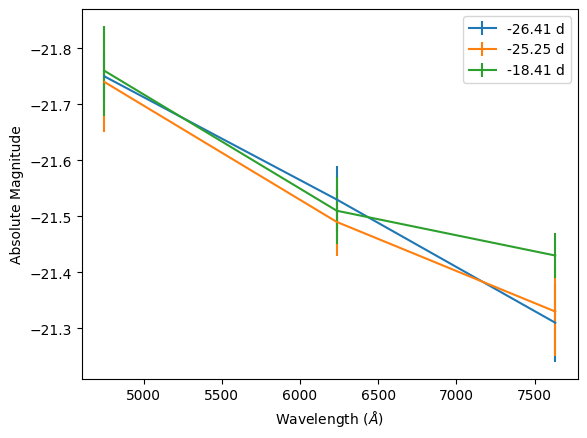

In [29]:
# Now we can plot the SED for each epoch

plt.errorbar([g_wave, r_wave, i_wave], \
             [sn_light_curve['g'][epoch1][0], sn_light_curve['r'][epoch1][0], sn_light_curve['i'][epoch1][0]], \
             yerr = [sn_light_curve['gerr'][epoch1][0], sn_light_curve['rerr'][epoch1][0], sn_light_curve['ierr'][epoch1][0]], \
            label = '-26.41 d')

# plt.errorbar() #Do this for epoch 2
plt.errorbar([g_wave, r_wave, i_wave], \
                [sn_light_curve['g'][epoch2][0], sn_light_curve['r'][epoch2][0], sn_light_curve['i'][epoch2][0]], \
                yerr = [sn_light_curve['gerr'][epoch2][0], sn_light_curve['rerr'][epoch2][0], sn_light_curve['ierr'][epoch2][0]], \
                label = '-25.25 d')

# plt.errorbar(???) #Do this for epoch 3
plt.errorbar([g_wave, r_wave, i_wave], \
                [sn_light_curve['g'][epoch3][0], sn_light_curve['r'][epoch3][0], sn_light_curve['i'][epoch3][0]], \
                yerr = [sn_light_curve['gerr'][epoch3][0], sn_light_curve['rerr'][epoch3][0], sn_light_curve['ierr'][epoch3][0]], \
                label = '-18.41 d')

plt.legend()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Absolute Magnitude')
plt.gca().invert_yaxis()

What do you see? Try plotting different epochs as well and see if you can notice the evolution of the SED shape. 

## Measuring temperature from the SED

We can fit an SED with the black body function to derive the temperature. This method assumes that the source emits like a black body, with no spectral features. In general, this works well for sources where spectral lines do not dominate the overall emission. For instance, supernovae near peak are very well explained by a black body. Old supernovae, on the ohter hands, have many strong emission lines; this makes the black body approximation less appropriate. For now, let's assume that a black body explains our SN 2015bn. 

In [45]:
# First, we will write a helper function that takes an epoch of SN 2015bn light curve and gives us the SED. 
# Note that the code for the last plot looks very messy, and we don't want to have to do this every time. 

# We want a function that will take the desired epoch, say -26.41 day from the first epoch we used for the last plot, 
# and return two arrays: one with gri photometry and one with gri uncertainty.
# We should be able to recreate the last plot using two arrays from this function. 

# This function should also check if the input epoch has any data in it, and returns None if not.

def get_SED_from_epoch(desired_epoch):
    """
    This function takes the epoch of observation and returns g, r, i photometry and uncertainties in 
    appropriate arrays.
    """
    epoch = sn_light_curve['epoch'] == desired_epoch
    if np.sum(epoch) == 1:
        SED_at_epoch = np.array([sn_light_curve['g'][epoch][0], sn_light_curve['r'][epoch][0], sn_light_curve['i'][epoch][0]])
        Err_at_epoch = np.array([sn_light_curve['gerr'][epoch][0], sn_light_curve['rerr'][epoch][0], sn_light_curve['ierr'][epoch][0]])
        return SED_at_epoch, Err_at_epoch
    else:
        print("This epoch has no data.")
        return None

In [52]:
# We will also define an array with wavelength so we don't have to rewrite that every time. 
wl_array = np.array([g_wave, r_wave, i_wave])
print(wl_array)

[4749.16 6235.29 7632.28]


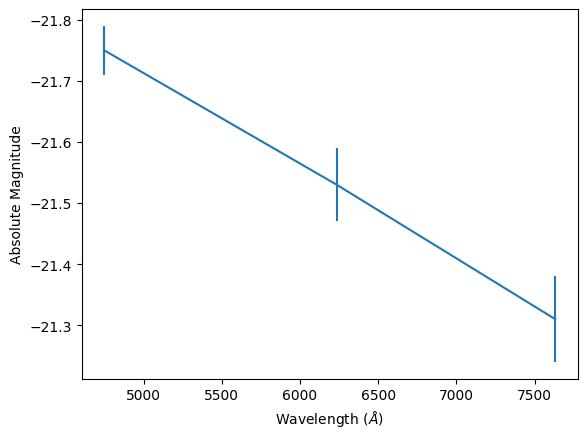

In [47]:
# Now let's use this to recreate the SED from -26.41 day

SED_at_epoch, Err_at_epoch = get_SED_from_epoch(-26.41)

plt.errorbar(wl_array, SED_at_epoch, yerr = Err_at_epoch)
    
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Absolute Magnitude')
plt.gca().invert_yaxis()

## Convert absolute magnitude to specific flux and wavelength to frequency

Recall that the AB magnitude scale means that an object with mag = 0 has a specific flux of $F_{\nu, 0} = 3631$ Jy. For an apparent magnitude, you can compute the observed flux from $F_\nu = F_{\nu, 0} 10^{-{\rm mag}/2.5}$. If the given magnitude is an absolute magnitude, this is an observed flux for a hypothetical observer located 10 parsec from the source. 

In [48]:
#Quick astropy constant and unit tutorial: Let's compute E = m c^2 for 1 gram of mass

E = 1*u.g * const.c**2
print(E)

#You can do unit conversion like this:
print(E.to(u.J))

#You can also convert this back to a normal number
print(E.to(u.J).value)

8.987551787368176e+16 m2 g / s2
89875517873681.77 J
89875517873681.77


In [49]:
#Write a function that takes the absolute AB magnitude and converts to flux unit
def mag2flux(mag, magerr):
    f0 = 3631.0 * u.Jy #Jansky
    flux = f0 * 10**(-mag/2.5)
    fluxerr = np.abs(flux * np.log(10)/2.5 * magerr) #Extra credit: derive this!
    return flux, fluxerr

In [50]:
#test out this function
mag2flux(SED_at_epoch, Err_at_epoch)

Flux_at_epoch, FluxErr_at_epoch = mag2flux(SED_at_epoch, Err_at_epoch)
print(Flux_at_epoch, FluxErr_at_epoch)

[1.81981085e+12 1.48602546e+12 1.21346219e+12] Jy [6.70443092e+10 8.21208015e+10 7.82347986e+10] Jy


In [55]:
#Now convert the wavelength array to frequency. We will get to use this soon. 
#use the astropy constant and unit package here as well
nu_array = const.c / (wl_array * u.angstrom)
print(nu_array)

# You can convert unit like this:
nu_array.to(u.Hz)

[63125.36490664 48079.95426035 39279.54136903] m / (Angstrom s)


<Quantity [6.31253649e+14, 4.80799543e+14, 3.92795414e+14] Hz>

## Black body radiation

The topic of black body radiation takes a good amount of time to explain. After all, this is one of the key issues that started quantum mechanics. In a nutshell, black body radiation is the spectrum you get from a perfect body that can absorb all light and reemit the energy via thermal radiation. The specific intensity of this spectrum is explained by the Planck function:

$B_\nu = \dfrac{2 h \nu^3}{c^2} \dfrac{1}{ e^{h \nu / k_B T} - 1} $

In [56]:
#Uncomment the line below to see all the constants available:
const?

Type:        module
String form: <module 'astropy.constants' from '/home/pkhamchuai/miniconda3/envs/astro/lib/python3.9/site-packages/astropy/constants/__init__.py'>
File:        ~/miniconda3/envs/astro/lib/python3.9/site-packages/astropy/constants/__init__.py
Docstring:  
Contains astronomical and physical constants for use in Astropy or other
places.

A typical use case might be::

    >>> from astropy.constants import c, m_e
    >>> # ... define the mass of something you want the rest energy of as m ...
    >>> m = m_e
    >>> E = m * c**2
    >>> E.to('MeV')  # doctest: +FLOAT_CMP
    <Quantity 0.510998927603161 MeV>

The following constants are available:

========== ============== ================ =========================
   Name        Value            Unit       Description
========== ============== ================ =========================
    G        6.6743e-11     m3 / (kg s2)   Gravitational constant
   N_A     6.02214076e+23    1 / (mol)     Avogadro's number
    R     

In [86]:
# Write a function that takes frequency nu and temperature T and outputs B_nu

def Bnu(nu, T):
    """
    Here, use astropy units and constants to your advantage so that unit conversion is taken care of
    """
    #Planck function goes here. Use the const? above to see the names for all the constants. 
    return 2*const.h*nu**3/const.c**2/(np.exp(const.h*nu/const.k_B/T)-1)

In [89]:
# Let's try out your function for 10,000 K
Bnu(nu_array, 10000*u.K)

<Quantity [1.88391440e-37, 1.81107238e-37, 1.59938703e-37] J m / Angstrom3>

In [90]:
Bnu(nu_array, 10000*u.K).to(u.Jy)

<Quantity [1.88391440e+19, 1.81107238e+19, 1.59938703e+19] Jy>

We can now convert the specific intensity to flux. We discussed this briefly in the previous lecture on photometry, but in brief, for an isotropically emitting body, the flux at the surface of the object with radius $R$ is $F_{\nu, \rm surface} = \pi I_\nu$. In this case for black body radiation, $I_\nu$ is just the Planck function, so $F_{\nu, \rm surface} = \pi B_\nu $

At any distance $d > R$, the flux decreases according to the inverse square law: $F_\nu(d) = F_{\nu, \rm surface} \frac{R^2}{d^2} $

In [110]:
# Write a function that takes frequency nu, temperature T, and black body radius R and gives the flux at 
# a distance d, default to 10 parsec
def Fnu(nu, T, R, d = 10*u.pc):
    #This should be F_nu(d) from the equation above. You should call the Bnu function above.
    return Bnu(nu, T)*np.pi*R**2/d**2

In [111]:
#Test this function for R = 1e5 Rsun. Convert the unit to Jy.
#use a finer wavelength array

wlwl = np.linspace(3000,9000,10000)
nunu = const.c/(wlwl*u.angstrom)

Fnu(nunu, 10000*u.K, 1e5*u.R_sun).to(u.Jy)

<Quantity [1.95792718e+12, 1.95864604e+12, 1.95936465e+12, ...,
           2.20566199e+12, 2.20551548e+12, 2.20536899e+12] Jy>

Text(0, 0.5, '$F_\\nu$ (Jy)')

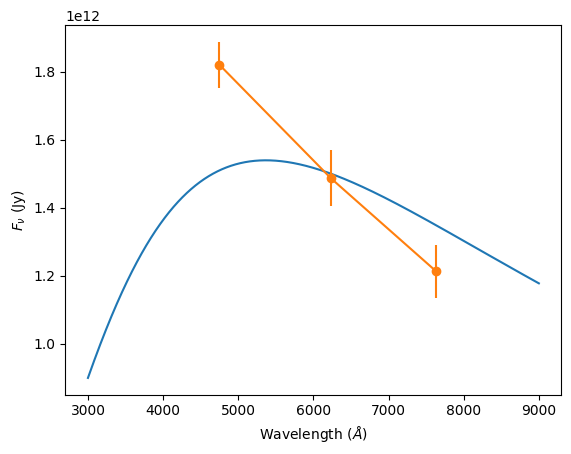

In [114]:
#Now make a plot comparing this black body curve to the flux of SN 2015bn
#Use wavelength in the x axis. Optical/IR astronomers dislike frequency!

#Here, you should tweak the temperature and radius to get the number similar to the observation.
#This does not have to be perfect, just close. 

T_guess = 9500*u.K
R_guess = 0.77e5*u.R_sun

plt.plot(wlwl, Fnu(nunu, T_guess, R_guess).to(u.Jy), '-')
plt.errorbar(wl_array, Flux_at_epoch, FluxErr_at_epoch, marker = 'o')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'$F_\nu$ (Jy)')

## Finally, actually fit the black body function to our data

We are almost at the end (of part 1)! Here, we will use a function fitting routine from scipy called curve_fit. Documentation for this routine can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In short, it takes a function f that has a form f(x, a, b, c,...) where x is the independent variable (wavelenght or frequency here) and a, b, c, ... are parameters we are trying to fit. It also takes the independent and depedent variables x and y (here wavelength/frequency and flux), then it tries to adjust a, b, c, ... to make f(x, a, b, c, ...) as close as y as possible. 

In [115]:
#We have to define the function to fit. This should be very similar to Fnu above, but for convenience, let it take
#wavelenght as x, and have T and R as the adjustable parameters

#Another quirk is that curve_fit cannot deal with astropy units. So let's give it just numerical value and we add 
#the units inside the function. Similarly, we also have to return a unitless number in Jansky

T_guess = 9500
R_guess = 0.77e5

def Fnu_to_fit(wl, T, R):
    nu = const.c/(wl*u.angstrom)
    T = T*u.K
    R = R*u.R_sun
    
    flux = Fnu(nu, T, R)
    return flux.to(u.Jy).value

#Clearly define x and y and y_err for curve fit
x = wl_array
y = Flux_at_epoch.to(u.Jy).value
y_err = FluxErr_at_epoch.to(u.Jy).value
print(x)
print(y)
print(y_err)

#Call curve_fit. Note that we use T_guess and R_guess as the initial value for the function.

result, covariance = curve_fit(Fnu_to_fit, x, y, sigma = y_err, absolute_sigma = True, p0 = (T_guess, R_guess))

[4749.16 6235.29 7632.28]
[1.81981085e+12 1.48602546e+12 1.21346219e+12]
[6.70443092e+10 8.21208015e+10 7.82347986e+10]


In [116]:
#Show the result
print(result)
print(covariance)

[13606.99622262 50380.64895488]
[[ 2003850.24184489 -8425241.36548048]
 [-8425241.36548048 35910478.8115224 ]]


Here, the list result contains the best-fit value for our two parameters, T and R in the units of Kelvin and Rsun. The covariance matrix gives us the estimates of the variance of the two parameters. 

In [117]:
best_T = result[0] * u.K
best_R = result[1] * u.R_sun
T_err = np.sqrt(np.diag(covariance))[0] *u.K
R_err = np.sqrt(np.diag(covariance))[1] *u.R_sun

In [118]:
print("The best fit temperature is %d +- %d K"%(best_T.value, T_err.value))
print("The best fit radius is %e +- %e Rsun"%(best_R.value, R_err.value))

The best fit temperature is 13606 +- 1415 K
The best fit radius is 5.038065e+04 +- 5.992535e+03 Rsun


Text(0, 0.5, '$F_\\nu$ (Jy)')

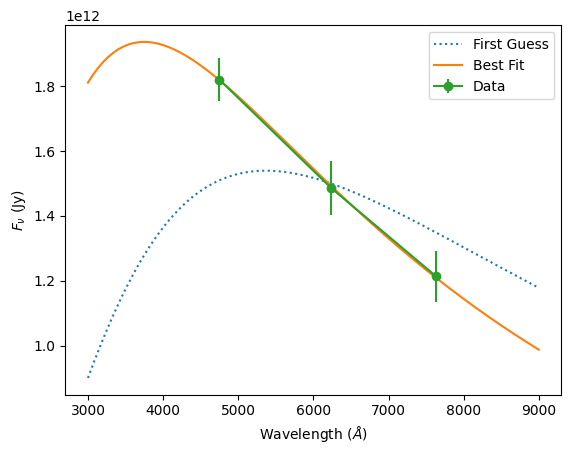

In [120]:
#Remake the last plot, but also with the best fit value

plt.plot(wlwl ,Fnu(nunu, T_guess*u.K, R_guess*u.R_sun).to(u.Jy), ':', label = 'First Guess')
plt.plot(wlwl ,Fnu(nunu, best_T, best_R).to(u.Jy), '-', label = 'Best Fit')

plt.errorbar(wl_array, Flux_at_epoch, FluxErr_at_epoch, marker = 'o', label = 'Data')

plt.legend()

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'$F_\nu$ (Jy)')

From the temperature and radius, we can calculate the black body luminosity via $L = 4 \pi R^2 \sigma T^4$ where $\sigma$ is the Stefan-Boltzmann constant. You get this by integrating $\pi B_\nu$ from $\nu = 0$ to $\infty$. See https://en.wikipedia.org/wiki/Stefan%E2%80%93Boltzmann_law

In [121]:
#Write a function to compute black body luminosity and uncertainty given T and R

def blackbodyL(best_T,best_R,T_err, R_err):
    #again, use the function above
    L_bb = 4*np.pi*best_R**2*const.sigma_sb*best_T**4
    L_bb_err = np.sqrt( (8*np.pi*best_R*const.sigma_sb*best_T**4 * R_err)**2 + \
                       (16*np.pi*best_R**2*const.sigma_sb*best_T**3 * T_err)**2) 
    return L_bb, L_bb_err

L_bb, L_bb_err =  blackbodyL(best_T,best_R,T_err, R_err)

In [122]:
print(L_bb.to(u.erg/u.s))
print(L_bb_err.to(u.erg/u.s))

3.0008354316033667e+44 erg / s
1.4383898562295893e+44 erg / s


## Bolometric Light Curve

You have done this for one epoch. Write a code that can loop through all the epochs of SN 2015bn and produce three plots showing the evolution of black body luminosity, temperature, and radius. This is one of the most basic task one has to do for a supernova study. These three plots allow you to see the evolution of the cataclysmic fireball from a dead star, and can be compared with theoretical models to learn about its nature. 

When you do this, think about the real observations. Usually, you don't have all the same filters observation every night. Maybe you have g and r for one night, and only r and i for the next. How do you deal with that? Some supernovae are hidden behind a dust cloud (recall our discussion on dust extinction). How do you deal with that? There are many more tehcniques astronomers use to deal with our often incomplete and sometimes downright terrible datasets. Stars and galaxies are far away and we can do nothing but look. 


In [130]:
# There are many ways to do this. 
# My favorite is to write a for loop going through different epochs we have,
# fit for T and R, compute L, then save them into lists. 


In [126]:
R = []
T = []
L = []
dR = []
dT = []
dL = []

for epoch in sn_light_curve['epoch']:
    #Get the SED at this epoch
    SED_at_epoch, Err_at_epoch = get_SED_from_epoch(epoch)
    #Convert to flux
    Flux_at_epoch, FluxErr_at_epoch = mag2flux(SED_at_epoch, Err_at_epoch)
    
    ##############
    #Fill in the gut here. Compute T and R from curve_fit, then L
    ##############

    result, covariance = curve_fit(Fnu_to_fit, x, Flux_at_epoch.to(u.Jy).value,
                                      sigma = FluxErr_at_epoch.to(u.Jy).value, absolute_sigma = True,
                                      p0 = (T_guess, R_guess))
    
    best_T = result[0] * u.K
    best_R = result[1] * u.R_sun
    T_err = np.sqrt(np.diag(covariance))[0] *u.K

    R_err = np.sqrt(np.diag(covariance))[1] *u.R_sun

    best_L, L_err =  blackbodyL(best_T,best_R,T_err, R_err)
    
    R += [best_R.to(u.cm).value]
    T += [best_T.to(u.K).value]
    L += [best_L.to(u.erg/u.s).value]
    
    dR += [R_err.to(u.cm).value]
    dT += [T_err.to(u.K).value]
    dL += [L_err.to(u.erg/u.s).value]
    

Text(0, 0.5, 'Temperature (K)')

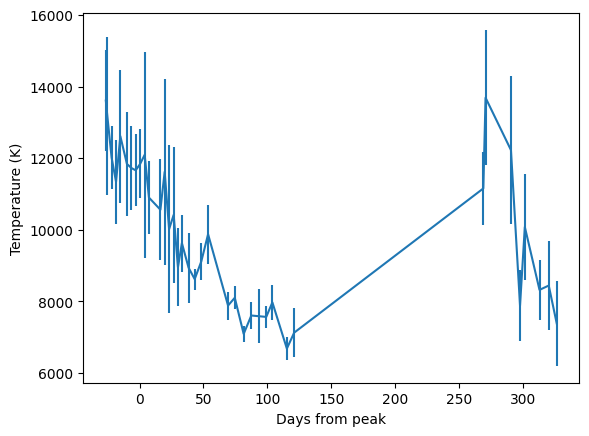

In [127]:
#Now we make the money plot, T L R as function of epoch
plt.errorbar(sn_light_curve['epoch'], T, dT)
plt.xlabel('Days from peak')
plt.ylabel('Temperature (K)')

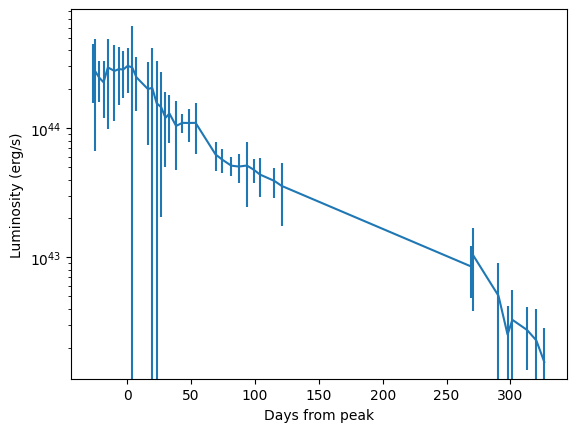

In [128]:
plt.errorbar(sn_light_curve['epoch'], L, dL)
plt.xlabel('Days from peak')
plt.ylabel('Luminosity (erg/s)')

plt.yscale('log')

Text(0, 0.5, 'Blackbody Radius (cm)')

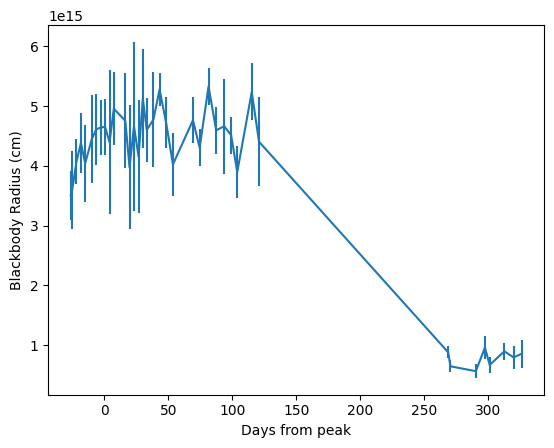

In [129]:
plt.errorbar(sn_light_curve['epoch'], R, dR)
plt.xlabel('Days from peak')
plt.ylabel('Blackbody Radius (cm)')

## Compare this to the published result for this supernova in Figure 17: https://arxiv.org/abs/1603.04748